In [21]:
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import uuid

from modules import UNet
from modules import UNet_2xUD
from modules import UNet_2xUD_halfchannels
from modules import Conv

seed = 449
random.seed(seed)
torch.manual_seed(seed)

# in cmd: tensorboard --logdir runs
# http://localhost:6006/#

In [22]:
class Diffusion:
    # diffusion tools: noise schedule, forward process (noising), sampling images
    def __init__(self, noise_steps=1000, beta_0=1e-4, beta_T=0.02, img_size=32, device="cuda", schedule="cosine"):
        self.noise_steps = noise_steps
        self.beta_0 = beta_0
        self.beta_T = beta_T
        self.img_size = img_size
        self.device = device

        self.beta = self.noise_schedule(schedule).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.flag = 0
        self.fixed = None
    
    def noise_schedule(self, type):
        """
        Creates the noise schedule used by the diffusion class

        Parameters
        ----------
        type : {"linear", "cosine"}
            The type of schedule to be created.
        """

        if type == "linear":
            return torch.linspace(self.beta_0, self.beta_T, self.noise_steps)
        elif type == "cosine":
            # from https://openreview.net/forum?id=-NEXDKk8gZ and https://github.com/lucidrains/denoising-diffusion-pytorch/
            s = 0.008
            t = torch.linspace(0, self.noise_steps, steps=self.noise_steps+1)
            f = torch.cos(((t / self.noise_steps) + s) / (1 + s) * (np.pi / 2)) ** 2
            alphas_hat = f / f[0]
            betas = 1 - (alphas_hat[1:] / alphas_hat[:-1])
            return torch.clip(betas, 0, self.beta_T)
    
    def noise_images(self, x, t):
        """
        Noises image using the reparameterization trick to noise in a single step.

        Returns
        ----------
        Tensor
            Image noised to timestep t
        epsilon : Tensor
            Noise added to image
        """

        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None] #TODO why this dimension?
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, disable_bar=True, out=None, fixed=False):
        # n: number of images to sample
        # algorithm 2 from DDPM paper

        model.eval()
        with torch.no_grad():
            # generate random vector as starting point, or use fixed noise
            if (fixed == False):
                x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            else:
                if self.flag == 0:
                    self.fixed = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
                    self.flag = 1
                x = self.fixed
            # run through all steps to denoise image
            for i in tqdm(reversed(range(1, self.noise_steps)), disable=disable_bar):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                if i > 1:
                    # TODO: why are we adding noise for backwards process?
                    noise = torch.randn_like(x)
                else:
                    # don't add noise for the last step
                    noise = torch.zeros_like(x)

                # denoise image using algorithm 2 step 4
                x = 1 / torch.sqrt(alpha) * (x - ((1-alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

                # save in array if given
                if out is not None:
                    generated = (x.clamp(-1, 1) + 1) / 2
                    generated = (generated*255).type(torch.uint8)
                    generated = torchvision.utils.make_grid(generated).cpu().numpy()
                    out.append(generated)
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x*255).type(torch.uint8)
        return x

In [23]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    # grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = images.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

def get_data(args):
    transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    # trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    # testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    # testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # trainset = torch.utils.data.ConcatDataset([trainset, testset])

    cat_idxs = np.where((np.array(trainset.targets) == 3))[0]
    catset = torch.utils.data.Subset(trainset, cat_idxs)

    catloader = torch.utils.data.DataLoader(catset, batch_size=args.batch_size, shuffle=True, num_workers=2)

    return catloader

In [24]:
img_list = []
def train(args):
    device = args.device
    if (args.model == "UNet"):
        model = UNet().to(device)
    elif (args.model == "UNet_2xUD"):
        model = UNet_2xUD().to(device)
    elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels().to(device)
    elif (args.model == "Conv"):
        model = Conv().to(device)
    
    dataloader = get_data(args)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device, schedule=args.schedule)
    writer = SummaryWriter(flush_secs=20)
    l = len(dataloader)

    progress = tqdm(range(args.epochs))
    for epoch in progress:
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)

            # get timestep, add correcet amount of noise
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            # try to predict the amount of noise
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.set_postfix(MSE=loss.item())
            writer.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        
        if (epoch+1) % 16 == 0:
            sampled_images = diffusion.sample(model, n=images.shape[0], disable_bar=True, fixed=True)
            img_grid = torchvision.utils.make_grid(sampled_images)
            img_list.append(img_grid)
            writer.add_image("generated", img_grid, epoch*l + i)
            save_images(img_grid, os.path.join("images/", args.run_name, f"{epoch}.jpg"))
            torch.save(model.state_dict(), os.path.join("models/CatDiffusion/", args.run_name, f"ckpt.pt"))
            torch.save({
                "epoch": epoch,
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss
            }, os.path.join("models/CatDiffusion/", args.run_name, f"train-state.pt"))

In [25]:
# import argparse
# parser = argparse.ArgumentParser()
import types
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-UNet-cosine-test"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
args.device = "cuda"
args.lr = 3e-4
# args.lr = 1e-3
args.model = "UNet"
args.schedule = "cosine"

impath = os.path.join("images/", args.run_name)
modelpath = os.path.join("models/CatDiffusion/", args.run_name)
outpath = os.path.join("output/", args.run_name)
# os.mkdir(impath)
# os.mkdir(modelpath)
# os.mkdir(outpath)

# TODO: test with random horizontal flips

train(args)

100%|██████████| 1024/1024 [8:18:21<00:00, 29.20s/it, MSE=0.0434]  


In [26]:
# cosine = Diffusion(schedule="cosine")
# linear = Diffusion(schedule="linear")

# dataloader = get_data(args)
# dataiter = iter(dataloader)

# plt.figure()
# raw = next(dataiter)[0].to('cuda')
# img = (torchvision.utils.make_grid(raw) / 2 + 0.5).permute(1, 2, 0).to('cpu').numpy()
# plt.imshow(img)

# for t in range(0, 1000, 100):
#     timesteps = torch.full((raw.shape[0],), t, device="cuda")
#     noised, epsilon = linear.noise_images(raw, timesteps)
#     noised_img = (torchvision.utils.make_grid(noised) / 2 + 0.5).permute(1, 2, 0).to('cpu').numpy()
#     plt.figure()
#     plt.imshow(noised_img)

# for t in range(0, 1000, 100):
#     timesteps = torch.full((raw.shape[0],), t, device="cuda")
#     noised, epsilon = cosine.noise_images(raw, timesteps)
#     noised_img = (torchvision.utils.make_grid(noised) / 2 + 0.5).permute(1, 2, 0).to('cpu').numpy()
#     plt.figure()
#     plt.imshow(noised_img)

999it [00:54, 18.46it/s]


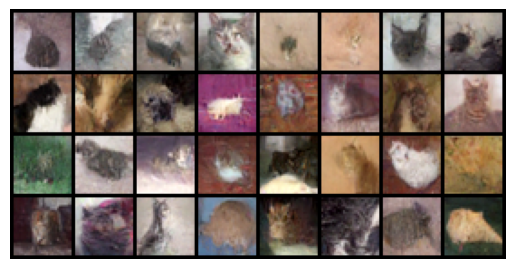

In [27]:
# original structure
path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet().to("cuda")
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD().to("cuda")
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels().to("cuda")
elif (args.model == "Conv"):
        model = Conv().to("cuda")


# structure reduced to 2x up down blocks
# args.run_name = "1e4lr"
# path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
# model = UNet_2xUD().to("cuda")

model.load_state_dict(torch.load(path))
diffusion = Diffusion(img_size=args.image_size, device="cuda")

iarr = []
sampled_images = diffusion.sample(model, n=32, disable_bar=False, out=iarr)
img_grid = torchvision.utils.make_grid(sampled_images)
save_images(img_grid, os.path.join("output/", args.run_name, f"{uuid.uuid4()}.png"))

ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [28]:
# fig = plt.figure()
# plt.axis("off")

# ims = [np.transpose(i, (1,2,0)) for i in iarr]
# final = copy.deepcopy(ims[-1])
# for i in range(100):
#     ims.append(copy.deepcopy(final))
# ims = np.array(ims)

# display = []
# for image in ims:
#     display.append([plt.imshow(image, animated=True)])
# ani = animation.ArtistAnimation(fig, display, interval=10, blit=True)
# plt.close()

# path = os.path.join("output/", args.run_name, f"{uuid.uuid4()}.mp4")
# ani.save(path)
# HTML(ani.to_html5_video())